<a href="https://colab.research.google.com/github/sandesh-kun/Vton/blob/main/TfinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Accessing Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# !sudo cp -v -r "/content/drive/MyDrive/ladi-vton/" "/content/drive/MyDrive/Final_Project"

# **Project Directory**

In [3]:
%cd /content/drive/MyDrive/Final_Project

/content/drive/.shortcut-targets-by-id/1Uo1iJ5_7Fa_nSfXnCVNDUqF80C17LcjE/Final_Project


In [4]:
!pip install torch==2.0.1 torchvision==0.15.2 opencv-python==4.7.0.72 diffusers==0.14.0 transformers==4.27.3 accelerate==0.18.0 clean-fid==0.1.35 torchmetrics[image]==0.11.4 wandb==0.14.0 matplotlib==3.7.1 tqdm xformers

# **Checking Cuda**

In [5]:
import torch
torch.cuda.is_available()

True

Clearing files from input and results folders

In [6]:
import os
import glob
import shutil
from PIL import Image

files = glob.glob('input/*/*/*.*')
for f in files:
  os.remove(f)

files = glob.glob('results/*/*/*.*')
for f in files:
  os.remove(f)

Resize Image 384x512

In [7]:
def resize_with_pad(im, target_width, target_height):
    '''
    Resize PIL image keeping ratio and using white background.
    '''
    target_ratio = target_height / target_width
    im_ratio = im.height / im.width
    if target_ratio > im_ratio:
        # It must be fixed by width
        resize_width = target_width
        resize_height = round(resize_width * im_ratio)
    else:
        # Fixed by height
        resize_height = target_height
        resize_width = round(resize_height / im_ratio)

    image_resize = im.resize((resize_width, resize_height), Image.ANTIALIAS)
    background = Image.new('RGBA', (target_width, target_height), (255, 255, 255, 255))
    offset = (round((target_width - resize_width) / 2), round((target_height - resize_height) / 2))
    background.paste(image_resize, offset)
    return background.convert('RGB')

Process Resize images Input and clothes images parallely

In [8]:
#Add pairs
def write_row(file_, *columns):
    print(*columns, sep='\t', end='\n', file=file_)

upper = open('input/upper_body/test_pairs_unpaired.txt', 'w')
lower = open('input/lower_body/test_pairs_unpaired.txt', 'w')
dresses = open('input/dresses/test_pairs_unpaired.txt', 'w')
all = open('input/test_pairs_paired.txt', 'w')

with open('images/test_pairs.txt', "r") as file:
    data = file.readlines()
    for line in data:
        word = line.split()
        if len(word) >= 3:  # Check if the line has at least 3 columns
            org_path = 'images/humans/' + word[0]
            if(word[2] == '0'):
                write_row(upper, '0'+word[0], word[1])
                write_row(all, '0'+word[0], word[1], word[2])
                res_path = 'input/upper_body/images/0' + word[0]
            elif(word[2] == '1'):
                write_row(lower, '1'+word[0], word[1])
                write_row(all, '1'+word[0], word[1], word[2])
                res_path = 'input/lower_body/images/1' + word[0]
            elif(word[2] == '2'):
                write_row(dresses, '2'+word[0], word[1])
                write_row(all, '2'+word[0], word[1], word[2])
                res_path = 'input/dresses/images/2' + word[0]
            image = Image.open(org_path)
            new = resize_with_pad(image, 384, 512)
            new.save(res_path)

upper.close()
lower.close()
dresses.close()
all.close()


<ipython-input-7-e04c8aed8ec9>:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image_resize = im.resize((resize_width, resize_height), Image.ANTIALIAS)


In [9]:
%cd preprocess

/content/drive/.shortcut-targets-by-id/1Uo1iJ5_7Fa_nSfXnCVNDUqF80C17LcjE/Final_Project/preprocess


Cloning Pytorch Openpose into Prprocess folder

In [10]:
!git clone https://github.com/Hzzone/pytorch-openpose.git
%cd pytorch-openpose

fatal: destination path 'pytorch-openpose' already exists and is not an empty directory.
/content/drive/.shortcut-targets-by-id/1Uo1iJ5_7Fa_nSfXnCVNDUqF80C17LcjE/Final_Project/preprocess/pytorch-openpose


Image is Processed in 3 classes, Upper, Lower, Dresses for pose estimation

In [11]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import copy
import numpy as np
import glob
import json
import os

from src import model
from src import util
from src.body import Body
from src.hand import Hand

body_estimation = Body('model/body_pose_model.pth')
for s in ['upper_body','lower_body','dresses']:
  input_path = '/content/drive/MyDrive/Final_Project/input/' + s + '/images/'
  output_path = '/content/drive/MyDrive/Final_Project/input/'+ s + '/skeletons/'
  keypoint_path = '/content/drive/MyDrive/Final_Project/input/'+ s + '/keypoints/'


  for images in glob.glob('*',root_dir = input_path):
      oriImg = cv2.imread(input_path+images)  # B,G,R order
      candidate, subset = body_estimation(oriImg)
      canvas = util.draw_bodypose(np.zeros_like(oriImg), candidate, subset)
      arr = candidate.tolist()
      vals = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0]
      for i in range(0,18):
        if len(arr)==i or arr[i][3] != vals[i]:
          arr.insert(i,[-1,-1,-1,vals[i]])

      keypoints = {'keypoints':arr[:18]}
      cv2.imwrite(output_path + images.replace('_0','_5'),canvas)
      with open(keypoint_path+ os.path.splitext(images)[0].replace('_0','_2') +".json" , 'w') as fin:
        fin.write(json.dumps(keypoints))

In [12]:
%cd ../..

/content/drive/.shortcut-targets-by-id/1Uo1iJ5_7Fa_nSfXnCVNDUqF80C17LcjE/Final_Project


In [13]:
%cd preprocess

/content/drive/.shortcut-targets-by-id/1Uo1iJ5_7Fa_nSfXnCVNDUqF80C17LcjE/Final_Project/preprocess


In [14]:
!pip install ninja

Processing images for Parsing

In [15]:
!git clone https://github.com/PeikeLi/Self-Correction-Human-Parsing
%cd Self-Correction-Human-Parsing

fatal: destination path 'Self-Correction-Human-Parsing' already exists and is not an empty directory.
/content/drive/.shortcut-targets-by-id/1Uo1iJ5_7Fa_nSfXnCVNDUqF80C17LcjE/Final_Project/preprocess/Self-Correction-Human-Parsing


In [16]:
!python simple_extractor.py --dataset 'atr' --model-restore '/content/drive/MyDrive/Final_Project/preprocess/Self-Correction-Human-Parsing/checkpoints/final.pth' --input-dir '/content/drive/MyDrive/Final_Project/input/upper_body/images/' --output-dir '/content/drive/MyDrive/Final_Project/input/upper_body/label_maps/'


Evaluating total class number 18 with ['Background', 'Hat', 'Hair', 'Sunglasses', 'Upper-clothes', 'Skirt', 'Pants', 'Dress', 'Belt', 'Left-shoe', 'Right-shoe', 'Face', 'Left-leg', 'Right-leg', 'Left-arm', 'Right-arm', 'Bag', 'Scarf']
0it [00:00, ?it/s]


In [17]:
!python simple_extractor.py --dataset 'atr' --model-restore '/content/drive/MyDrive/Final_Project/preprocess/Self-Correction-Human-Parsing/checkpoints/final.pth' --input-dir '/content/drive/MyDrive/Final_Project/input/lower_body/images/' --output-dir '/content/drive/MyDrive/Final_Project/input/lower_body/label_maps/'


Evaluating total class number 18 with ['Background', 'Hat', 'Hair', 'Sunglasses', 'Upper-clothes', 'Skirt', 'Pants', 'Dress', 'Belt', 'Left-shoe', 'Right-shoe', 'Face', 'Left-leg', 'Right-leg', 'Left-arm', 'Right-arm', 'Bag', 'Scarf']
100% 1/1 [00:00<00:00,  1.57it/s]


In [18]:
!python simple_extractor.py --dataset 'atr' --model-restore '/content/drive/MyDrive/Final_Project/preprocess/Self-Correction-Human-Parsing/checkpoints/final.pth' --input-dir '/content/drive/MyDrive/Final_Project/input/dresses/images/' --output-dir '/content/drive/MyDrive/Final_Project/input/dresses/label_maps/'


Evaluating total class number 18 with ['Background', 'Hat', 'Hair', 'Sunglasses', 'Upper-clothes', 'Skirt', 'Pants', 'Dress', 'Belt', 'Left-shoe', 'Right-shoe', 'Face', 'Left-leg', 'Right-leg', 'Left-arm', 'Right-arm', 'Bag', 'Scarf']
100% 1/1 [00:00<00:00,  1.32it/s]


In [19]:
%cd ../..

/content/drive/.shortcut-targets-by-id/1Uo1iJ5_7Fa_nSfXnCVNDUqF80C17LcjE/Final_Project


In [20]:
%cd preprocess

/content/drive/.shortcut-targets-by-id/1Uo1iJ5_7Fa_nSfXnCVNDUqF80C17LcjE/Final_Project/preprocess


In [21]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

fatal: destination path 'detectron2' already exists and is not an empty directory.


Checking Detectron and Cuda Avaibility

In [22]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.0 ; cuda:  cu118
detectron2: 0.6


Importing Detectorn2 for trainning

In [23]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [24]:
%cd detectron2/projects/DensePose

/content/drive/.shortcut-targets-by-id/1Uo1iJ5_7Fa_nSfXnCVNDUqF80C17LcjE/Final_Project/preprocess/detectron2/projects/DensePose


Boosting libraries with av

In [25]:
!pip install av

Running apply_net.py with arguments

In [26]:
!python apply_net.py show configs/densepose_rcnn_R_50_FPN_s1x.yaml \
https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_50_FPN_s1x/165712039/model_final_162be9.pkl \
/content/drive/MyDrive/Final_Project/input/upper_body/images dp_segm -v --output /content/drive/MyDrive/Final_Project/input/upper_body/dense/

[08/30 21:09:33 apply_net]: Loading config from configs/densepose_rcnn_R_50_FPN_s1x.yaml
[08/30 21:09:33 apply_net]: Loading model from https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_50_FPN_s1x/165712039/model_final_162be9.pkl
[08/30 21:09:36 apply_net]: Loading data from /content/drive/MyDrive/Final_Project/input/upper_body/images
WARNING [08/30 21:09:36 apply_net]: No input images for /content/drive/MyDrive/Final_Project/input/upper_body/images


Specifies the new paths for the model checkpoint, input images, and output directory

In [27]:
!python apply_net.py show configs/densepose_rcnn_R_50_FPN_s1x.yaml \
https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_50_FPN_s1x/165712039/model_final_162be9.pkl \
/content/drive/MyDrive/Final_Project/input/lower_body/images dp_segm -v  --output /content/drive/MyDrive/Final_Project/input/lower_body/dense/

[08/30 21:09:40 apply_net]: Loading config from configs/densepose_rcnn_R_50_FPN_s1x.yaml
[08/30 21:09:40 apply_net]: Loading model from https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_50_FPN_s1x/165712039/model_final_162be9.pkl
[08/30 21:09:42 apply_net]: Loading data from /content/drive/MyDrive/Final_Project/input/lower_body/images
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
[08/30 21:09:43 apply_net]: Processing /content/drive/MyDrive/Final_Project/input/lower_body/images/1yy_0.jpg
[08/30 21:09:43 apply_net]: Output saved to /content/drive/MyDrive/Final_Project/input/lower_body/dense/1yy_5.png


In [28]:
!python apply_net.py show configs/densepose_rcnn_R_50_FPN_s1x.yaml \
https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_50_FPN_s1x/165712039/model_final_162be9.pkl \
/content/drive/MyDrive/Final_Project/input/dresses/images dp_segm -v   --output /content/drive/MyDrive/Final_Project/input/dresses/dense/

[08/30 21:09:54 apply_net]: Loading config from configs/densepose_rcnn_R_50_FPN_s1x.yaml
[08/30 21:09:54 apply_net]: Loading model from https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_50_FPN_s1x/165712039/model_final_162be9.pkl
[08/30 21:09:57 apply_net]: Loading data from /content/drive/MyDrive/Final_Project/input/dresses/images
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
[08/30 21:09:58 apply_net]: Processing /content/drive/MyDrive/Final_Project/input/dresses/images/2San_0.jpg
[08/30 21:09:58 apply_net]: Output saved to /content/drive/MyDrive/Final_Project/input/dresses/dense/2San_5.png


In [29]:
!python apply_net.py dump configs/densepose_rcnn_R_50_FPN_s1x.yaml \
https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_50_FPN_s1x/165712039/model_final_162be9.pkl \
/content/drive/MyDrive/Final_Project/input/upper_body/images -v --output /content/drive/MyDrive/Final_Project/input/upper_body/dense/

[08/30 21:10:02 apply_net]: Loading config from configs/densepose_rcnn_R_50_FPN_s1x.yaml
[08/30 21:10:02 apply_net]: Loading model from https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_50_FPN_s1x/165712039/model_final_162be9.pkl
[08/30 21:10:03 apply_net]: Loading data from /content/drive/MyDrive/Final_Project/input/upper_body/images
WARNING [08/30 21:10:03 apply_net]: No input images for /content/drive/MyDrive/Final_Project/input/upper_body/images


In [30]:
!python apply_net.py dump configs/densepose_rcnn_R_50_FPN_s1x.yaml \
https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_50_FPN_s1x/165712039/model_final_162be9.pkl \
/content/drive/MyDrive/Final_Project/input/lower_body/images -v --output /content/drive/MyDrive/Final_Project/input/lower_body/dense/

[08/30 21:10:08 apply_net]: Loading config from configs/densepose_rcnn_R_50_FPN_s1x.yaml
[08/30 21:10:08 apply_net]: Loading model from https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_50_FPN_s1x/165712039/model_final_162be9.pkl
[08/30 21:10:10 apply_net]: Loading data from /content/drive/MyDrive/Final_Project/input/lower_body/images
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
[08/30 21:10:12 apply_net]: Processing /content/drive/MyDrive/Final_Project/input/lower_body/images/1yy_0.jpg
[08/30 21:10:12 apply_net]: Output saved to /content/drive/MyDrive/Final_Project/input/lower_body/dense/1yy_5_uv.npz


In [31]:
!python apply_net.py dump configs/densepose_rcnn_R_50_FPN_s1x.yaml \
https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_50_FPN_s1x/165712039/model_final_162be9.pkl \
/content/drive/MyDrive/Final_Project/input/dresses/images -v --output /content/drive/MyDrive/Final_Project/input/dresses/dense/

[08/30 21:10:15 apply_net]: Loading config from configs/densepose_rcnn_R_50_FPN_s1x.yaml
[08/30 21:10:15 apply_net]: Loading model from https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_50_FPN_s1x/165712039/model_final_162be9.pkl
[08/30 21:10:17 apply_net]: Loading data from /content/drive/MyDrive/Final_Project/input/dresses/images
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
[08/30 21:10:18 apply_net]: Processing /content/drive/MyDrive/Final_Project/input/dresses/images/2San_0.jpg
[08/30 21:10:18 apply_net]: Output saved to /content/drive/MyDrive/Final_Project/input/dresses/dense/2San_5_uv.npz


Project Folder

In [32]:
%cd ../../../..

/content/drive/.shortcut-targets-by-id/1Uo1iJ5_7Fa_nSfXnCVNDUqF80C17LcjE/Final_Project


Process grayscale images under specific directories within the input directory.

In [33]:
from google.colab.patches import cv2_imshow
import cv2
import glob
pattern = 'input/*/dense/*'
mp ={0: 0, 128: 18, 64: 4, 132: 19, 69: 5, 136: 20, 75: 6, 140: 21, 145: 22, 85: 9, 150: 23, 90: 10, 155: 24, 121: 16, 105: 13, 111: 14, 52: 2, 117: 15, 57: 3, 124: 17,
     2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 9: 9, 10: 10, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24}

lut = np.zeros((256, 1), dtype=np.uint8)

for i in range(0,256):
    lut[i] = mp.get(i) or mp[min(mp.keys(), key = lambda key: abs(key-i))]

for images in glob.glob(pattern):
    if images.endswith(".png"):
      image = cv2.imread(images,cv2.IMREAD_GRAYSCALE)
      cv2.imwrite(images,cv2.LUT(image,lut))

This dictionary provides a mapping for a range of original pixel values to new pixel values. For example, if an original pixel value in the image is 128, it will be remapped to 18

Code scans through files in subdirectories under the input directory. If a file's name ends with _1.jpg or _1.png, the code removes the file using the os.remove() function.

In [34]:
#Clear
import os
import glob
import shutil
from PIL import Image

files = glob.glob('input/*/*/*.*')
for f in files:
  if f.endswith("_1.jpg") or f.endswith("_1.png"):
    os.remove(f)

Resizing and Padding is added

In [35]:
def resize_with_pad(im, target_width, target_height):
    '''
    Resize PIL image keeping ratio and using white background.
    '''
    target_ratio = target_height / target_width
    im_ratio = im.height / im.width
    if target_ratio > im_ratio:
        # It must be fixed by width
        resize_width = target_width
        resize_height = round(resize_width * im_ratio)
    else:
        # Fixed by height
        resize_height = target_height
        resize_width = round(resize_height / im_ratio)

    image_resize = im.resize((resize_width, resize_height), Image.ANTIALIAS)
    background = Image.new('RGBA', (target_width, target_height), (255, 255, 255, 255))
    offset = (round((target_width - resize_width) / 2), round((target_height - resize_height) / 2))
    background.paste(image_resize, offset)
    return background.convert('RGB')

Saves the processed images back to the same paths.


In [36]:
for c in ['dresses','upper_body','lower_body']:
  files = glob.glob('images/'+c+'/*.*')
  path = 'input/' + c + '/images/'
  for f in files:
    if f.endswith("_1.jpg"):
      res = path +os.path.basename(f)
      shutil.copy (f, res)
      image = Image.open(res)
      new = resize_with_pad(image,384,512)
      new.save(res)

<ipython-input-35-e04c8aed8ec9>:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image_resize = im.resize((resize_width, resize_height), Image.ANTIALIAS)


Processes images to match clothing category

In [37]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import copy
import glob
import json
import os

def otsu(img , n  , x ):
    img_gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(img_gray,255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,n,x)
    return thresh

def contour(img):
    edges = cv2.dilate(cv2.Canny(img,200,255),None)
    cnt = sorted(cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2], key=cv2.contourArea)[-1]
    mask = np.zeros((img.shape[0],img.shape[1]), np.uint8)
    masked = cv2.drawContours(mask, [cnt],-1, 255, -1)
    return masked

def get_cloth_mask(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(image)
    cv2.drawContours(mask, contours, -1, (255, 255, 255), -1)
    return mask

def write_edge(C_path,E_path):
    img = cv2.imread(C_path)
    res = get_cloth_mask(img)
    if(np.mean(res)<100):
        ot = otsu(img,11,0.6)
        res = contour(ot)
    cv2.imwrite(E_path,res)

for s in ['upper_body','lower_body','dresses']:
  input_path = '/content/drive/MyDrive/Final_Project/input/' + s + '/images/'
  output_path = '/content/drive/MyDrive/Final_Project/input/'+ s + '/masks/'
  for images in glob.glob('*',root_dir = input_path):
      if images.endswith("_1.jpg"):
        write_edge(input_path + images , output_path+ os.path.splitext(images)[0] +".png")

Cleaning Up the objects that are no longer needed

In [38]:
import gc
gc.collect()

42

This test.sh contains command for model to activate for **Cloth Swap**

In [39]:
!sh test.sh

2023-08-30 21:10:25.718801: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Some weights of the model checkpoint at laion/CLIP-ViT-H-14-laion2B-s32B-b79K were not used when initializing CLIPVisionModelWithProjection: ['text_model.encoder.layers.21.self_attn.q_proj.weight', 'text_model.encoder.layers.23.self_attn.out_proj.weight', 'text_model.encoder.layers.20.self_attn.q_proj.bias', 'text_model.encoder.layers.9.self_attn.k_proj.bias', 'text_model.encoder.layers.17.layer_norm1.bias', 'text_model.encoder.layers.3.mlp.fc2.bias', 'text_model.encoder.layers.8.self_attn.v_proj.weight', 'text_model.encoder.layers.9.mlp.fc1.weight', 'text_model.encoder.layers.4.layer_norm2.bias', 'text_model.encoder.layers.0.self_attn.out_proj.bias', 'text_model.encoder.layers.23.self_attn.v_proj.weight', 'text_model.encoder.layers.3.layer_norm1.bias', 'text_model.encoder.layers.2.self_attn.q_proj.bias', 'text_model.encoder.layers.8.mlp.fc1.weight', 'text_model.e

In [40]:
#!sh metrics.sh

Show Output

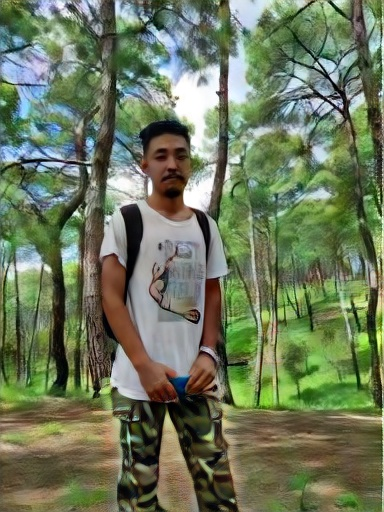

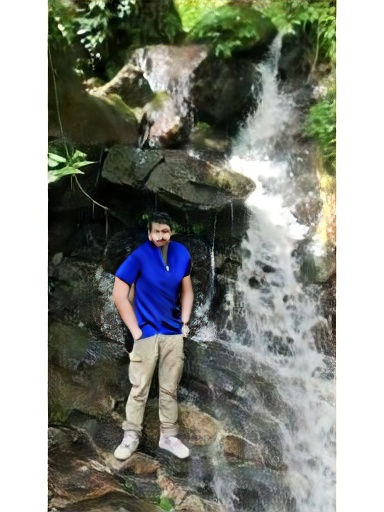

In [41]:
from google.colab.patches import cv2_imshow
import cv2
import glob

pattern = 'results/unpaired/*/*'
for images in glob.glob(pattern):
    if (images.endswith(".png") or images.endswith(".jpg") or images.endswith(".jpeg")):
      cv2_imshow(cv2.imread(images, cv2.IMREAD_UNCHANGED))

Face correction

In [42]:
%cd /content/drive/MyDrive/Final_Project

/content/drive/.shortcut-targets-by-id/1Uo1iJ5_7Fa_nSfXnCVNDUqF80C17LcjE/Final_Project


In [43]:
!pip install mediapipe

In [44]:
import cv2
import os
import glob
import mediapipe
import numpy as np
import pandas as pd
from google.colab.patches import cv2_imshow

In [45]:
# dresscode = 'final'

In [46]:
# filepath = os.path.join('input', f"test_pairs_paired.txt")
# with open(filepath, 'r') as f:
#     lines = f.read().splitlines()
# org_paths = sorted(
#       [os.path.join('input', category, 'images', line.strip().split()[0]) for line in lines for
#         category in ['lower_body', 'upper_body', 'dresses'] if
#         os.path.exists(os.path.join('input', category, 'images', line.strip().split()[0]))])
# res_paths = sorted(
#                 [os.path.join('results/unpaired', category, name) for category in ['lower_body', 'upper_body', 'dresses'] for
#                  name in os.listdir(os.path.join('results/unpaired', category)) if
#                  os.path.exists(os.path.join('results/unpaired', category, name))])

In [47]:
# print("Number of org_paths:", len(org_paths))
# print("Number of res_paths:", len(res_paths))


In [49]:
# assert len(org_paths) == len(res_paths)
#sz = len(org_paths)

In [ ]:
# for iter in range(0,sz):
#   org_img = cv2.imread(org_paths[iter])
#   org_res = cv2.imread(res_paths[iter])
#   h,w = int(org_img.shape[0]/2),org_img.shape[1]
#   img = org_img[:h,:w]
#   res = org_res[:h,:w]
#   cv2_imshow(res)
#   mp_face_mesh = mediapipe.solutions.face_mesh
#   face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)
#   results = face_mesh.process(img[:,:,::-1])
#   if(results.multi_face_landmarks == None):
#      print('miss')
#      continue
#   landmarks = results.multi_face_landmarks[0]
#   df = pd.DataFrame(list(mp_face_mesh.FACEMESH_FACE_OVAL),columns=['p1','p2'])
#   routes_idx = []

#   p2 = df.iloc[0]['p1']
#   p2 = df.iloc[0]['p2']
#   for i in range(0,df.shape[0]):
#     obj = df[df['p1'] == p2]
#     p1 = obj['p1'].values[0]
#     p2 = obj['p2'].values[0]

#     cur = []
#     cur.append(p1)
#     cur.append(p2)
#     routes_idx.append(cur)

#   routes = []
#   for sid,tid in routes_idx:
#     sxy = landmarks.landmark[sid]
#     txy = landmarks.landmark[tid]

#     source = (int(sxy.x * img.shape[1]) , int(sxy.y * img.shape[0]))
#     target = (int(txy.x * img.shape[1]) , int(txy.y * img.shape[0]))

#     routes.append(source)
#     routes.append(target)

#   mask = np.zeros((img.shape[0],img.shape[1]))
#   mask = cv2.fillConvexPoly(mask,np.array(routes),1)
#   mask = mask.astype(bool)
#   res[mask] = img[mask]
#   cv2_imshow(res)
#   org_img[:h,:w] = img
#   org_res[:h,:w] = res
#   cv2.imwrite(res_paths[iter].replace('results/unpaired','final').replace('_0.jpg','_'+dresscode+'.jpg'),org_res)

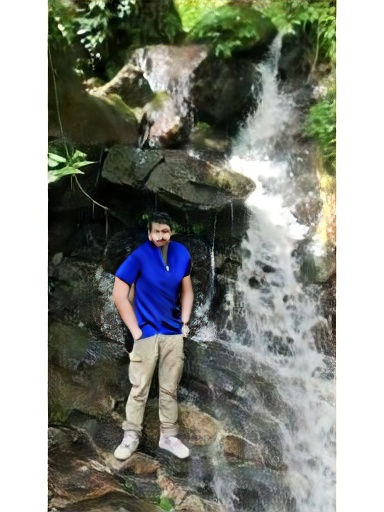

Miss: No face landmarks found.


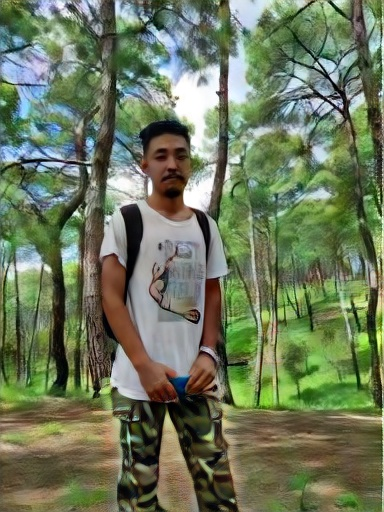

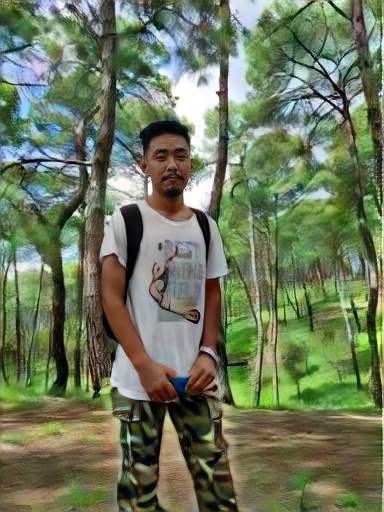

In [50]:
dresscode = 'final'
filepath = os.path.join('input', f"test_pairs_paired.txt")
with open(filepath, 'r') as f:
    lines = f.read().splitlines()
org_paths = sorted(
      [os.path.join('input', category, 'images', line.strip().split()[0]) for line in lines for
        category in ['lower_body', 'upper_body', 'dresses'] if
        os.path.exists(os.path.join('input', category, 'images', line.strip().split()[0]))])
res_paths = sorted(
                [os.path.join('results/unpaired', category, name) for category in ['lower_body', 'upper_body', 'dresses'] for
                 name in os.listdir(os.path.join('results/unpaired', category)) if
                 os.path.exists(os.path.join('results/unpaired', category, name))])
assert len(org_paths) == len(res_paths)
sz = len(org_paths)

for iter in range(0, sz):
    org_img = cv2.imread(org_paths[iter])
    org_res = cv2.imread(res_paths[iter])

    cv2_imshow(org_res)

    mp_face_mesh = mediapipe.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)
    results = face_mesh.process(org_img[:,:,::-1])

    if results.multi_face_landmarks is None:
        print('Miss: No face landmarks found.')
        continue

    landmarks = results.multi_face_landmarks[0]

    df = pd.DataFrame(list(mp_face_mesh.FACEMESH_FACE_OVAL), columns=['p1', 'p2'])
    routes_idx = []

    p2 = df.iloc[0]['p1']
    p2 = df.iloc[0]['p2']

    for i in range(0, df.shape[0]):
        obj = df[df['p1'] == p2]
        p1 = obj['p1'].values[0]
        p2 = obj['p2'].values[0]

        cur = []
        cur.append(p1)
        cur.append(p2)
        routes_idx.append(cur)

    routes = []

    for sid, tid in routes_idx:
        sxy = landmarks.landmark[sid]
        txy = landmarks.landmark[tid]

        source = (int(sxy.x * org_img.shape[1]), int(sxy.y * org_img.shape[0]))
        target = (int(txy.x * org_img.shape[1]), int(txy.y * org_img.shape[0]))

        routes.append(source)
        routes.append(target)

    mask = np.zeros((org_img.shape[0], org_img.shape[1]))
    mask = cv2.fillConvexPoly(mask, np.array(routes), 1)
    mask = mask.astype(bool)
    org_res[mask] = org_img[mask]

    cv2_imshow(org_res)

    cv2.imwrite(res_paths[iter].replace('results/unpaired', 'final').replace('_0.jpg', '_' + dresscode + '.jpg'), org_res)
